<a href="https://colab.research.google.com/github/tkhan3/machinelearning/blob/master/Shameen_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
#import pandas as pd
!google-drive-ocamlfuse drive
!apt-get -qq install -y graphviz && pip install -q pydot
!pip3 install seaborn==0.9.0
import pydot
!mkdir -p drive
!google-drive-ocamlfuse drive

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 110851 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
import pandas as pd
from datetime import datetime
import os
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
from sklearn.metrics import (accuracy_score, log_loss, classification_report)
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


In [0]:
drive_path = 'drive/DL_COLAB/'

HR_ANALYTICS_PATH = os.path.join(drive_path,"hr_analytics")

def load_hr_data(filename, file_path=HR_ANALYTICS_PATH):
    csv_path = os.path.join(file_path, filename)
    return pd.read_csv(csv_path,sep="|")

In [0]:
hr_data_full = load_hr_data("new_Attrition_Data.csv")

In [0]:
hr_data_full_trim = hr_data_full[["Age","Attrition","BusinessTravel","Department","DistanceFromHome","Education","Gender","HourlyRate","JobInvolvement","JobLevel","JobRole","JobSatisfaction","MaritalStatus","MonthlyIncome","NumCompaniesWorked","PercentSalaryHike","PerformanceRating","StockOptionLevel","TotalWorkingYears","TrainingTimesLastYear","WorkLifeBalance","YearsAtCompany","YearsInCurrentRole","YearsSinceLastPromotion","YearsWithCurrManager","OverTime"]]

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_index in split.split(hr_data_full, hr_data_full["Attrition"]):
    hr_data_train = hr_data_full_trim.loc[train_index]
    hr_data_test = hr_data_full_trim.loc[test_index]

In [7]:
hr_data_train.describe()

,Age,DistanceFromHome,Education,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000
mean,36.922902,9.311413,2.914588,65.651550,2.730915,2.060469,2.722600,6472.625850,2.684051,15.215420,3.156463,0.791383,11.292517,2.773243,2.761905,6.990930,4.223734,2.184429,4.139078
std,9.122388,8.105754,1.026630,20.356772,0.706682,1.096398,1.108076,4662.442825,2.470083,3.674503,0.363431,0.854118,7.797057,1.276452,0.709776,6.094931,3.610559,3.236867,3.595089
min,18.000000,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,0.000000,11.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,2.000000,2.000000,48.000000,2.000000,1.000000,2.000000,2901.500000,1.000000,12.000000,3.000000,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,7.000000,3.000000,66.000000,3.000000,2.000000,3.000000,4936.000000,2.000000,14.000000,3.000000,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,14.000000,4.000000,83.000000,3.000000,3.000000,4.000000,8252.500000,4.000000,18.000000,3.000000,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,29.000000,5.000000,100.000000,4.000000,5.000000,4.000000,19973.000000,9.000000,25.000000,4.000000,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f99b7501be0>,
      dtype=object)

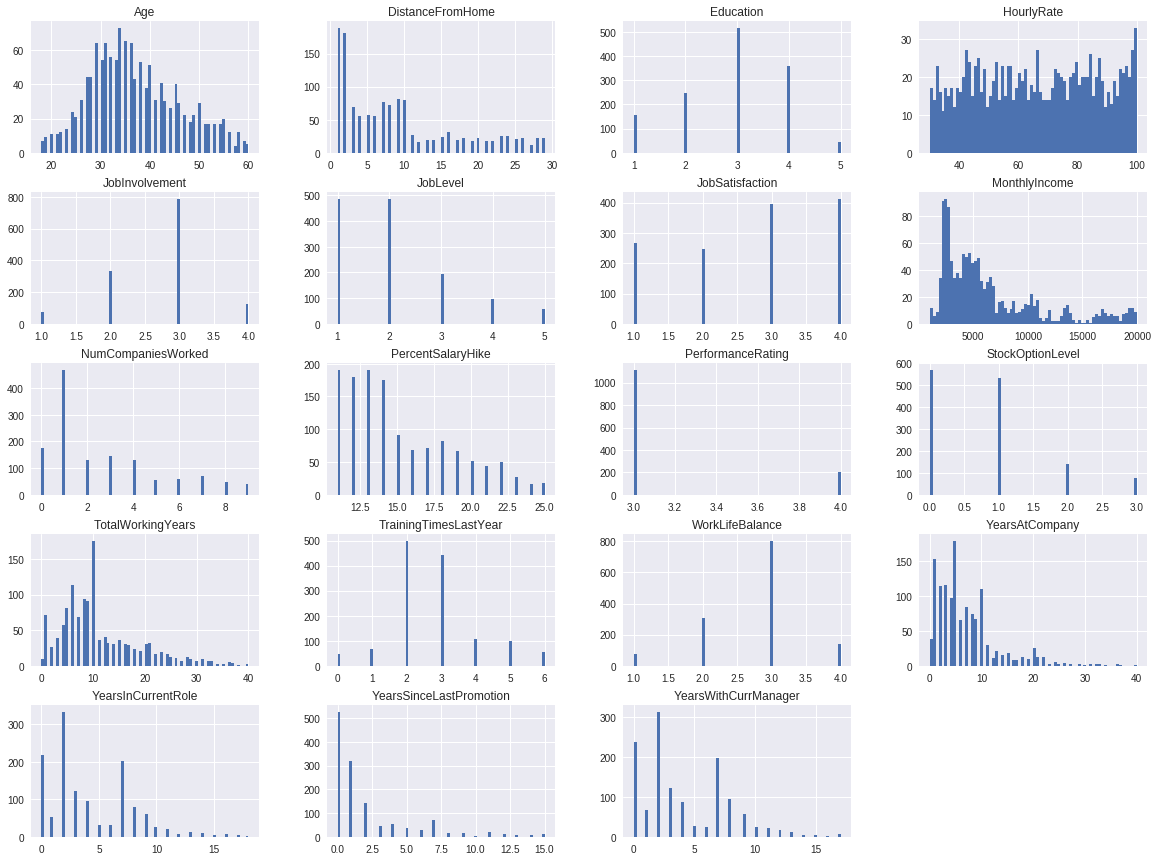

In [8]:
hr_data_train.hist(bins=70, figsize=(20,15))

In [0]:
hr_data_train_label = hr_data_train["Attrition"].copy()
hr_data_test_label =  hr_data_test["Attrition"].copy()

hr_data_train = hr_data_train.drop("Attrition",axis=1)
hr_data_test = hr_data_test.drop("Attrition",axis=1)

In [10]:
print (hr_data_train.shape)
print (hr_data_test.shape)
print (hr_data_train_label.shape)
print (hr_data_test_label.shape)

(1323, 25)
(147, 25)
(1323,)
(147,)


In [0]:
cat_attribute = ["BusinessTravel","Department","Gender","JobRole","MaritalStatus","OverTime"]

In [0]:
numeric_atribute = list(set(hr_data_train.columns) ^ set (cat_attribute))

In [0]:
imputer = SimpleImputer(strategy="median")

In [0]:
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],index=X.columns)
        return self
    def transform(self, X, y=None):
    #    return X.fillna(self.most_frequent_)
        return X

In [0]:
# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [0]:
num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(numeric_atribute)),
        ("imputer", SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

In [0]:
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(cat_attribute)),
#        ("imputer", MostFrequentImputer()),
        ("cat_encoder",OneHotEncoder(sparse=False,handle_unknown='ignore' )),
        ])

In [0]:
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [0]:
x_train  = preprocess_pipeline.fit_transform(hr_data_train)
x_test =  preprocess_pipeline.transform(hr_data_test)

In [21]:
print (x_train.shape)
print (x_test.shape)

(1323, 72)
(147, 72)


In [0]:
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(hr_data_train_label)
y_test = le.fit_transform(hr_data_test_label)

In [23]:
print (y_train.shape)
print (y_test.shape)

(1323,)
(147,)


In [24]:
#train SVM Based Model
svm_clf = SVC(gamma="auto",random_state=42)
svm_clf.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [25]:
svm_scores = cross_val_score(svm_clf, x_train, y_train, cv=10)
y_train_pred_svm = cross_val_predict(svm_clf, x_train, y_train, cv=10)
print (svm_scores.mean())

0.8450501253132833


In [26]:
confusion_matrix(y_train, y_train_pred_svm)

array([[1108,    2],
       [ 203,   10]])

In [27]:
tn, fp, fn, tp = confusion_matrix(y_train,y_train_pred_svm).ravel()
print (tn)
print (fp)
print (fn)
print (tp)

1108
2
203
10


In [28]:
classification_report(y_train, y_train_pred_svm)

'              precision    recall  f1-score   support\n\n           0       0.85      1.00      0.92      1110\n           1       0.83      0.05      0.09       213\n\n   micro avg       0.85      0.85      0.85      1323\n   macro avg       0.84      0.52      0.50      1323\nweighted avg       0.84      0.85      0.78      1323\n'

In [0]:
y_test_pred_svm = svm_clf.predict(x_test)

In [30]:
confusion_matrix(y_test,y_test_pred_svm)

array([[123,   0],
       [ 23,   1]])

In [32]:
param_grid = [{"weights":["uniform","distance"],"n_neighbors":[2,3,4,5]}]
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=10, verbose=3, n_jobs=-1)
grid_search.fit(x_train, y_train)
print (grid_search.best_params_)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    3.9s


{'n_neighbors': 4, 'weights': 'uniform'}


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   14.0s finished


In [0]:
knn_clf = KNeighborsClassifier(n_neighbors=4,weights='uniform')

In [34]:
knn_clf.fit(x_train,y_train)
knn_scores = cross_val_score(knn_clf, x_train, y_train, cv=10)
y_train_pred_knn = cross_val_predict(knn_clf, x_train, y_train, cv=10)
print (knn_scores.mean())

0.8397698792435635


In [35]:
tn, fp, fn, tp = confusion_matrix(y_train,y_train_pred_knn).ravel()
print (tn)
print (fp)
print (fn)
print (tp)

1101
9
203
10


In [36]:
classification_report(y_train, y_train_pred_knn)

'              precision    recall  f1-score   support\n\n           0       0.84      0.99      0.91      1110\n           1       0.53      0.05      0.09       213\n\n   micro avg       0.84      0.84      0.84      1323\n   macro avg       0.69      0.52      0.50      1323\nweighted avg       0.79      0.84      0.78      1323\n'

In [0]:
y_test_pred_knn = knn_clf.predict(x_test)

In [38]:
confusion_matrix(y_test,y_test_pred_knn).ravel()

array([123,   0,  23,   1])

In [39]:
classification_report(y_test, y_test_pred_knn)

'              precision    recall  f1-score   support\n\n           0       0.84      1.00      0.91       123\n           1       1.00      0.04      0.08        24\n\n   micro avg       0.84      0.84      0.84       147\n   macro avg       0.92      0.52      0.50       147\nweighted avg       0.87      0.84      0.78       147\n'

In [40]:
xgboost_clf = XGBClassifier(random_state=42)
xgboost_clf.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [41]:
xgboost_scores = cross_val_score(xgboost_clf, x_train, y_train, cv=10)
y_train_pred_xgboost = cross_val_predict(xgboost_clf, x_train, y_train, cv=10)
xgboost_scores.mean()

0.8601902483481432

In [42]:
tn, fp, fn, tp = confusion_matrix(y_train,y_train_pred_xgboost).ravel()
print (tn)
print (fp)
print (fn)
print (tp)

1075
35
150
63


In [43]:
classification_report(y_train, y_train_pred_xgboost)

'              precision    recall  f1-score   support\n\n           0       0.88      0.97      0.92      1110\n           1       0.64      0.30      0.41       213\n\n   micro avg       0.86      0.86      0.86      1323\n   macro avg       0.76      0.63      0.66      1323\nweighted avg       0.84      0.86      0.84      1323\n'

In [0]:
y_test_pred_xgboost = xgboost_clf.predict(x_test)

In [45]:
tn, fp, fn, tp = confusion_matrix(y_test,y_test_pred_xgboost).ravel()
print (tn)
print (fp)
print (fn)
print (tp)

119
4
20
4


In [46]:
classification_report(y_test, y_test_pred_xgboost)

'              precision    recall  f1-score   support\n\n           0       0.86      0.97      0.91       123\n           1       0.50      0.17      0.25        24\n\n   micro avg       0.84      0.84      0.84       147\n   macro avg       0.68      0.57      0.58       147\nweighted avg       0.80      0.84      0.80       147\n'

In [47]:
param_grid = [{"learning_rate":[.001,.01,.1],"max_depth":[1,2,3],"n_estimators":[100,110,120]}]
grid_search = GridSearchCV(xgboost_clf, param_grid, cv=10, verbose=3, n_jobs=-1)
grid_search.fit(x_train, y_train)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   37.9s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'learning_rate': [0.001, 0.01, 0.1], 'max_depth': [1, 2, 3], 'n_estimators': [100, 110, 120]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [48]:
print (grid_search.best_params_)

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 110}


In [49]:
xgboost_clf = XGBClassifier(random_state=42,max_depth=2,n_estimators=110,learning_rate=0.1)
xgboost_clf.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=110,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [50]:
xgboost_scores = cross_val_score(xgboost_clf, x_train, y_train, cv=10)
y_train_pred_xgboost = cross_val_predict(xgboost_clf, x_train, y_train, cv=10)
xgboost_scores.mean()

0.8654591023012076

In [51]:
tn, fp, fn, tp = confusion_matrix(y_train,y_train_pred_xgboost).ravel()
print (tn)
print (fp)
print (fn)
print (tp)

1089
21
157
56


In [52]:
classification_report(y_train, y_train_pred_xgboost)

'              precision    recall  f1-score   support\n\n           0       0.87      0.98      0.92      1110\n           1       0.73      0.26      0.39       213\n\n   micro avg       0.87      0.87      0.87      1323\n   macro avg       0.80      0.62      0.66      1323\nweighted avg       0.85      0.87      0.84      1323\n'

In [0]:
y_test_xgboost = xgboost_clf.predict(x_test)

In [54]:
classification_report(y_test, y_test_xgboost)

'              precision    recall  f1-score   support\n\n           0       0.86      0.98      0.92       123\n           1       0.62      0.21      0.31        24\n\n   micro avg       0.85      0.85      0.85       147\n   macro avg       0.74      0.59      0.61       147\nweighted avg       0.82      0.85      0.82       147\n'

In [55]:
tn, fp, fn, tp = confusion_matrix(y_test,y_test_pred_xgboost).ravel()
print (tn)
print (fp)
print (fn)
print (tp)

119
4
20
4


In [56]:
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [57]:
x_train.shape

(1323, 72)

In [0]:
# create model
neural_net = Sequential()
neural_net.add(Dense(8, input_dim=72, activation='relu'))
#neural_net.add(Dense(12, activation='relu'))
#neural_net.add(Dense(12, activation='relu'))
#neural_net.add(Dense(12, activation='relu'))
neural_net.add(Dense(12, activation='relu'))
neural_net.add(Dense(1, activation='sigmoid'))
# Compile model
neural_net.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [74]:
neural_net.fit(x_train, y_train, validation_split=0.1,epochs=1500, batch_size=10)

Train on 1190 samples, validate on 133 samples
Epoch 1/1500
1190/1190 [==============================] - 1s 434us/step - loss: 0.4423 - acc: 0.8454 - val_loss: 0.4824 - val_acc: 0.7820
Epoch 2/1500
1190/1190 [==============================] - 0s 147us/step - loss: 0.3829 - acc: 0.8454 - val_loss: 0.4480 - val_acc: 0.7820
Epoch 3/1500
1190/1190 [==============================] - 0s 139us/step - loss: 0.3495 - acc: 0.8462 - val_loss: 0.4152 - val_acc: 0.7820
Epoch 4/1500
1190/1190 [==============================] - 0s 140us/step - loss: 0.3252 - acc: 0.8681 - val_loss: 0.4118 - val_acc: 0.8346
Epoch 5/1500
1190/1190 [==============================] - 0s 144us/step - loss: 0.3040 - acc: 0.8857 - val_loss: 0.4342 - val_acc: 0.8421
Epoch 6/1500
1190/1190 [==============================] - 0s 137us/step - loss: 0.2944 - acc: 0.8933 - val_loss: 0.4172 - val_acc: 0.8496
Epoch 7/1500
1190/1190 [==============================] - 0s 141us/step - loss: 0.2728 - acc: 0.9034 - val_loss: 0.4311 - val

In [75]:
scores = neural_net.evaluate(x_train,y_train)

1323/1323 [==============================] - 0s 25us/step


In [76]:
print("\n%s: %.2f%%" % (neural_net.metrics_names[1], scores[1]*100))


acc: 97.66%


In [0]:
y_train_pred_neural_net = neural_net.predict_classes(x_train)

In [0]:
y_test_pred_neural_net = neural_net.predict_classes(x_test)

In [79]:
confusion_matrix(y_train,y_train_pred_neural_net)

array([[1099,   11],
       [  20,  193]])

In [80]:
confusion_matrix(y_test,y_test_pred_neural_net)

array([[116,   7],
       [ 16,   8]])

In [81]:
tn, fp, fn, tp = confusion_matrix(y_test,y_test_pred_neural_net).ravel()
print (tn)
print (fp)
print (fn)
print (tp)

116
7
16
8


In [0]:
from imblearn.over_sampling import SMOTE

In [0]:
oversampler=SMOTE(random_state=0)
oversampler=SMOTE(random_state=0)
smote_train, smote_target = oversampler.fit_sample(x_train,y_train)

In [97]:
print (x_train.shape)
print (y_train.shape)
print (smote_train.shape)

(1323, 72)
(1323,)
(2220, 72)


In [99]:
neural_net.fit(smote_train, smote_target, validation_split=0.1,epochs=1500, batch_size=10)

Train on 1998 samples, validate on 222 samples
Epoch 1/1500
1998/1998 [==============================] - 1s 277us/step - loss: 0.6255 - acc: 0.6496 - val_loss: 0.6349 - val_acc: 0.7117
Epoch 2/1500
1998/1998 [==============================] - 0s 135us/step - loss: 0.5067 - acc: 0.7713 - val_loss: 0.5255 - val_acc: 0.7973
Epoch 3/1500
1998/1998 [==============================] - 0s 130us/step - loss: 0.4471 - acc: 0.8128 - val_loss: 0.4808 - val_acc: 0.8108
Epoch 4/1500
1998/1998 [==============================] - 0s 132us/step - loss: 0.4173 - acc: 0.8208 - val_loss: 0.5190 - val_acc: 0.7613
Epoch 5/1500
1998/1998 [==============================] - 0s 134us/step - loss: 0.3999 - acc: 0.8268 - val_loss: 0.4056 - val_acc: 0.8288
Epoch 6/1500
1998/1998 [==============================] - 0s 131us/step - loss: 0.3882 - acc: 0.8363 - val_loss: 0.3798 - val_acc: 0.8243
Epoch 7/1500
1998/1998 [==============================] - 0s 130us/step - loss: 0.3772 - acc: 0.8453 - val_loss: 0.4161 - val

In [0]:
y_train_pred_neural_net = neural_net.predict_classes(x_train)

In [101]:
confusion_matrix(y_train,y_train_pred_neural_net)

array([[1101,    9],
       [   0,  213]])

In [0]:
y_test_pred_neural_net = neural_net.predict_classes(x_test)

In [122]:
confusion_matrix = confusion_matrix(y_test,y_test_pred_neural_net)

TypeError: ignored

In [120]:
tn, fp, fn, tp = confusion_matrix
print (tn)
print (fp)
print (fn)
print (tp)

ValueError: ignored

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import itertools

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')

Confusion matrix, without normalization
[[103  20]
 [ 15   9]]


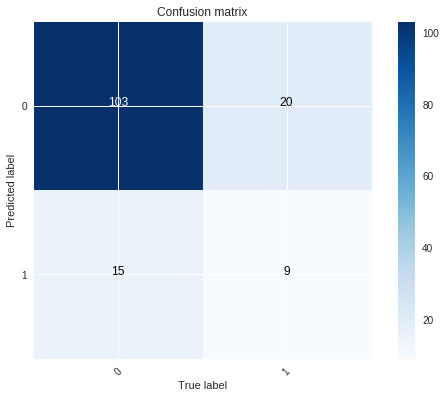

In [119]:
plot_confusion_matrix(confusion_matrix,[0,1])